In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import requests

from datetime import datetime
import time
import os

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
# 코인 리스트 받아오기
url = 'https://api.upbit.com/v1/market/all?isDetails=true'

headers = {"accept": "application/json"}
res = requests.get(url, headers=headers)

df = pd.DataFrame(res.json())
df = df.loc[df['market'].str.contains('KRW')]
df['market'] = df['market'].str.strip('KRW-')
coinlist = list(df['market'])
coinlist

['BTC',
 'ETH',
 'NEO',
 'MTL',
 'XRP',
 'ETC',
 'SNT',
 'AVES',
 'XEM',
 'QTUM',
 'LS',
 'STEEM',
 'XLM',
 'ARD',
 'A',
 'STORJ',
 'GRS',
 'ADA',
 'SBD',
 'PO',
 'BTG',
 'ICX',
 'EOS',
 'TRX',
 'SC',
 'ONT',
 'ZIL',
 'POLYX',
 'ZRX',
 'LOOM',
 'BCH',
 'BAT',
 'IOST',
 'CVC',
 'IQ',
 'IOTA',
 'HIFI',
 'ONG',
 'GAS',
 'UPP',
 'ELF',
 'NC',
 'BSV',
 'THETA',
 'QKC',
 'BTT',
 'MOC',
 'TFUEL',
 'MANA',
 'AN',
 'AERGO',
 'ATOM',
 'TT',
 'GAME2',
 'MBL',
 'AXP',
 'HBA',
 'MED',
 'ML',
 'STPT',
 'ORBS',
 'VET',
 'CHZ',
 'STMX',
 'DKA',
 'HIVE',
 'AVA',
 'AHT',
 'LIN',
 'XTZ',
 'BORA',
 'JST',
 'CRO',
 'TON',
 'SXP',
 'HUNT',
 'DOT',
 'MVL',
 'STRAX',
 'AQT',
 'GLM',
 'META',
 'FCT2',
 'CB',
 'SAND',
 'HPO',
 'DOGE',
 'STRIKE',
 'PUNDIX',
 'FLO',
 'AXS',
 'STX',
 'XEC',
 'SOL',
 'MATIC',
 'AAVE',
 '1INCH',
 'ALGO',
 'NEA',
 'AVAX',
 'T',
 'CELO',
 'GMT',
 'APT',
 'SHIB',
 'MAS',
 'ARB',
 'EGLD',
 'SUI',
 'GRT',
 'BLU',
 'IMX',
 'SEI',
 'MINA',
 'CTC',
 'AST',
 'ID',
 'PYTH',
 'MNT',
 'AKT',
 '

In [3]:
# 코인 별 파일 받아와서 하나의 데이터 프레임으로 합치기
dfs = []

for coin in coinlist:
    file_name = f'coin_1day/upbit_{coin}_prices_2023_days.csv'
    
    if os.path.exists(file_name):
        df = pd.read_csv(file_name).drop('Unnamed: 0', axis=1)
    else:
        continue
        
    # 빈 파일이 있다.
    if len(df) != 0:
        condition = (df['candle_date_time_utc'] >= '2022-12-31') & (df['candle_date_time_utc'] <= '2023-12-31')
        df = df[condition]
    dfs.append(df)
    
df_coins = pd.concat(dfs, ignore_index=True)
df_coins.head()

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,prev_closing_price,change_price,change_rate
0,KRW-BTC,2022-12-31,2022-12-31T09:00:00,21086000.0,21249000.0,20966000.0,21079000.0,1672531199722,6.253054e+10,2960.900095,21070000.0,9000.0,0.000427
1,KRW-BTC,2023-01-01,2023-01-01T09:00:00,21079000.0,21171000.0,21002000.0,21123000.0,1672617597561,3.135794e+10,1486.467553,21079000.0,44000.0,0.002087
2,KRW-BTC,2023-01-02,2023-01-02T09:00:00,21128000.0,21400000.0,21047000.0,21215000.0,1672703999647,5.484883e+10,2578.844531,21123000.0,92000.0,0.004355
3,KRW-BTC,2023-01-03,2023-01-03T09:00:00,21209000.0,21451000.0,21178000.0,21351000.0,1672790398972,4.477008e+10,2097.615306,21215000.0,136000.0,0.006411
4,KRW-BTC,2023-01-04,2023-01-04T09:00:00,21351000.0,21732000.0,21341000.0,21588000.0,1672876797009,5.338029e+10,2479.248182,21351000.0,237000.0,0.011100


In [4]:
# 코인 이름에 KRW 제거
df_coins['market'] = df_coins['market'].str[4:]

In [5]:
# 전일 거래대금에 비해 2배 이상 급등하는 조건으로 데이터 추출
df_coins.loc[df_coins['candle_acc_trade_price'] > 2 * df_coins['candle_acc_trade_price'].shift(), 'double_up'] = True
df_coins = df_coins[df_coins['candle_date_time_utc'] >= '2023-01-01']
df_coins.reset_index(drop=True)

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,prev_closing_price,change_price,change_rate,double_up
0,BTC,2023-01-01,2023-01-01T09:00:00,21079000.0,21171000.0,21002000.0,21123000.0,1672617597561,3.135794e+10,1.486468e+03,21079000.0,44000.0,0.002087,NaN
1,BTC,2023-01-02,2023-01-02T09:00:00,21128000.0,21400000.0,21047000.0,21215000.0,1672703999647,5.484883e+10,2.578845e+03,21123000.0,92000.0,0.004355,NaN
2,BTC,2023-01-03,2023-01-03T09:00:00,21209000.0,21451000.0,21178000.0,21351000.0,1672790398972,4.477008e+10,2.097615e+03,21215000.0,136000.0,0.006411,NaN
3,BTC,2023-01-04,2023-01-04T09:00:00,21351000.0,21732000.0,21341000.0,21588000.0,1672876797009,5.338029e+10,2.479248e+03,21351000.0,237000.0,0.011100,NaN
4,BTC,2023-01-05,2023-01-05T09:00:00,21589000.0,21641000.0,21404000.0,21575000.0,1672963199288,7.670565e+10,3.563010e+03,21588000.0,-13000.0,-0.000602,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33810,GRT,2023-12-27,2023-12-27T09:00:00,267.0,272.0,247.0,255.0,1703721574638,1.193789e+10,4.663414e+07,267.0,-12.0,-0.044944,NaN
33811,GRT,2023-12-28,2023-12-28T09:00:00,255.0,270.0,251.0,252.0,1703807993131,2.118269e+10,8.125003e+07,255.0,-3.0,-0.011765,NaN
33812,GRT,2023-12-29,2023-12-29T09:00:00,252.0,256.0,239.0,244.0,1703894399963,1.324197e+10,5.378081e+07,252.0,-8.0,-0.031746,NaN
33813,GRT,2023-12-30,2023-12-30T09:00:00,244.0,245.0,235.0,240.0,1703980761535,5.955023e+09,2.481044e+07,244.0,-4.0,-0.016393,NaN


In [6]:
# timestamp 형식으로 바꿔서 새로운 열 만들기
df_coins['timestamp_utc'] = pd.to_datetime(df_coins['candle_date_time_utc'])
df_coins['timestamp_utc'] = df_coins['timestamp_utc'].apply(lambda x: x.timestamp())

In [7]:
# merge를 위한 데이터 프레임을 만든다.
for_concat = pd.DataFrame([1]*365)
for_concat.index = df_coins['timestamp_utc'].unique()
for_concat.index.name = 'timestamp_utc'
for_concat.reset_index(inplace=True)
for_concat

,timestamp_utc,0
0,1.672531e+09,1
1,1.672618e+09,1
2,1.672704e+09,1
3,1.672790e+09,1
4,1.672877e+09,1
...,...,...
360,1.703635e+09,1
361,1.703722e+09,1
362,1.703808e+09,1
363,1.703894e+09,1


In [8]:
# 전일에 비해 거래대금이 2배 이상 상승한 코인들을 코인 이름 기준으로 시간을 묶어 timestamp 형식의 벡터를 거리계산해 가까운지 계산
grouped_df = df_coins[df_coins['double_up'] == True].groupby('market')['timestamp_utc']

merged = for_concat
for name, group in grouped_df:
    temp = group.to_frame()
    temp[f'{name}'] = 1
    merged = merged.merge(temp, on='timestamp_utc', how='left')

merged = merged.fillna(0)
merged

,timestamp_utc,0,1INCH,AAVE,ADA,AERGO,AHT,ALGO,APT,AQT,...,TT,UPP,VET,XEC,XEM,XLM,XRP,XTZ,ZIL,ZRX
0,1.672531e+09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.672618e+09,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.672704e+09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.672790e+09,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.672877e+09,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,1.703635e+09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
361,1.703722e+09,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
362,1.703808e+09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,1.703894e+09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
def cal_distance(df_features):
    # 열들 간의  거리 계산
    distance_matrix = pdist(df_features.T, metric='euclidean') # cosine 
    
    # 계층적 군집 분석 수행
    linked = linkage(distance_matrix, method='ward')
    return linked

In [10]:
df_features = merged.loc[:, '1INCH':]
linked = cal_distance(df_features)

In [11]:
# 덴드로그램 시각화
def plot_dendrogram(linked):
    plt.figure(figsize=(20, 10))
    plt.rc('font', size=17)
    dendrogram(linked, labels=df_features.columns)
    plt.title('Dendrogram for Coin Clustering')
    plt.xlabel('Coins')
    plt.ylabel('Euclidean Distance')
    plt.xticks(fontsize=13)
    plt.show()

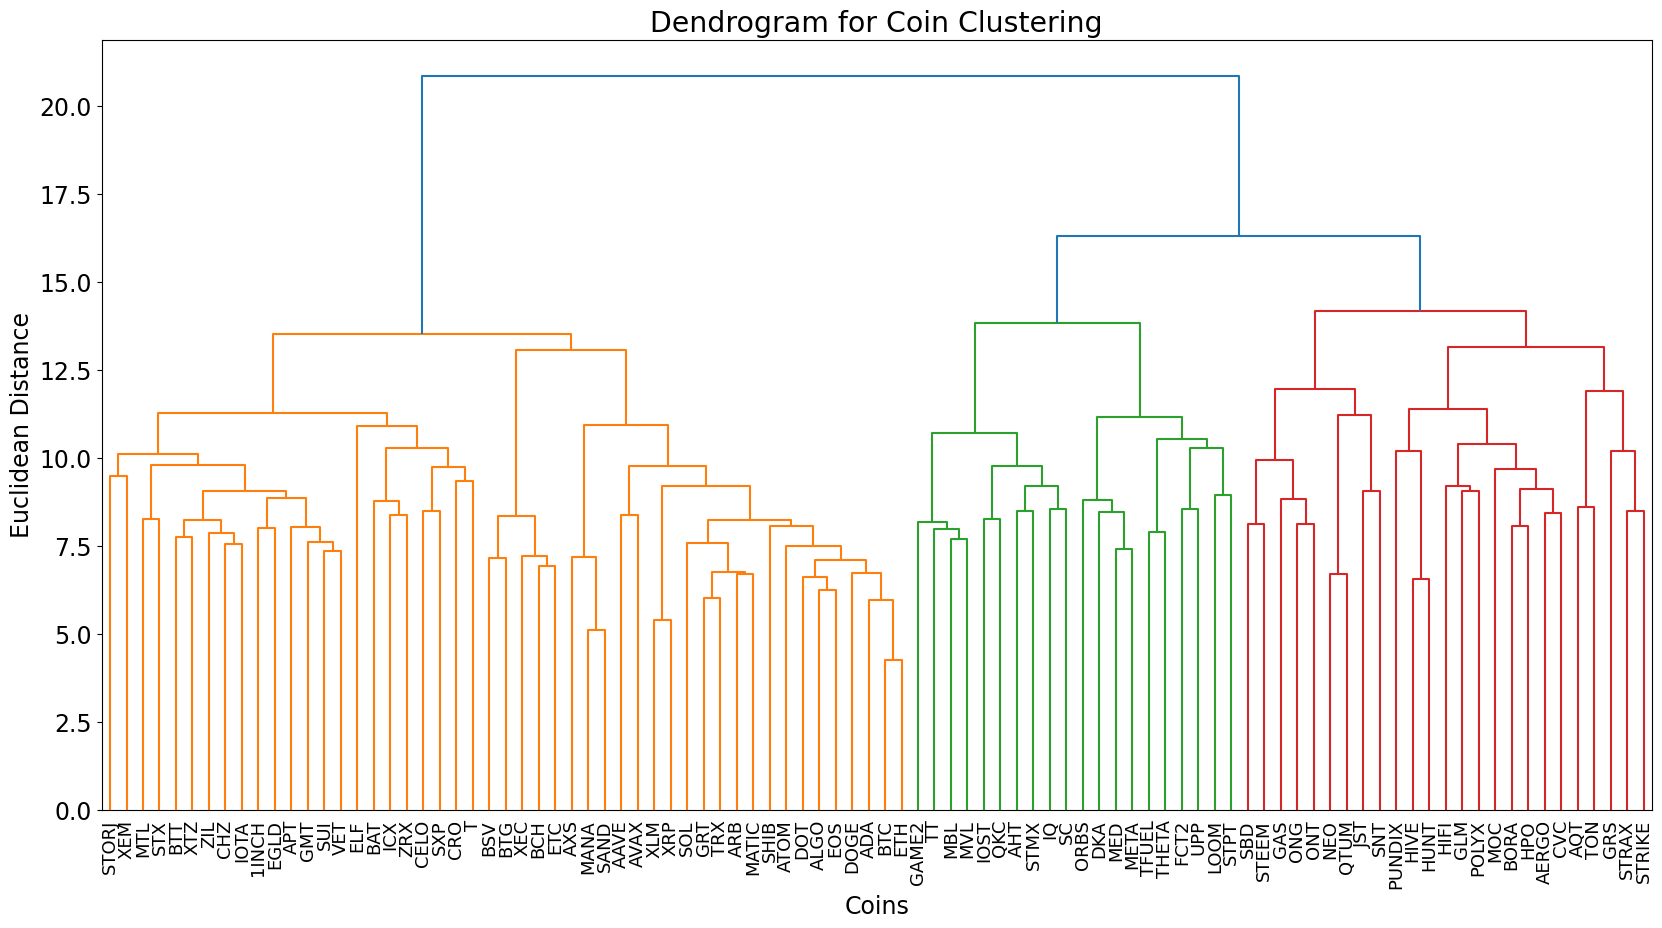

In [12]:
plot_dendrogram(linked)

In [13]:
# 실제로 겹치는 날짜 개수 확인
def check_ups(coin1, coin2):
    up_coins = df_coins[df_coins['double_up'] == True]
    count = 0
    coin1_ups = up_coins[up_coins['market'] == coin1].candle_date_time_utc.values
    coin2_ups = up_coins[up_coins['market'] == coin2].candle_date_time_utc.values
    for value in coin1_ups:
        if value in coin2_ups:
            count += 1
            
    print(f"{coin1} 상승한 일 수 : {len(coin1_ups)}")
    print(f"{coin2} 상승한 일 수 : {len(coin2_ups)}")
    print(f"상승한 날 겹치는 일 수 : {count}")

In [14]:
check_ups('NEO', 'QTUM')

NEO 상승한 일 수 : 69
QTUM 상승한 일 수 : 66
상승한 날 겹치는 일 수 : 45


In [15]:
def cluster_result(linked, df_features, num):
    # 원하는 군집 수 설정
    num_clusters = num
    
    # fcluster 함수를 사용하여 군집화
    clusters = fcluster(linked, num_clusters, criterion='maxclust')
    
    # 군집 결과를 데이터프레임으로 저장
    clustered_coins = pd.DataFrame({'Coin': df_features.columns, 'Cluster': clusters})
    
    # 각 군집의 요소를 확인
    for cluster_num in range(1, num_clusters + 1):
        print(f"Cluster {cluster_num}:")
        print(clustered_coins[clustered_coins['Cluster'] == cluster_num]['Coin'].tolist())

    return clustered_coins

In [16]:
clustered_coins = cluster_result(linked, df_features, 30)

Cluster 1:
['STORJ', 'XEM']
Cluster 2:
['MTL', 'STX']
Cluster 3:
['1INCH', 'APT', 'BTT', 'CHZ', 'EGLD', 'GMT', 'IOTA', 'SUI', 'VET', 'XTZ', 'ZIL']
Cluster 4:
['BAT', 'ICX', 'ZRX']
Cluster 5:
['CELO', 'SXP']
Cluster 6:
['CRO', 'T']
Cluster 7:
['ELF']
Cluster 8:
['BCH', 'BSV', 'BTG', 'ETC', 'XEC']
Cluster 9:
['AXS', 'MANA', 'SAND']
Cluster 10:
['AAVE', 'AVAX']
Cluster 11:
['ADA', 'ALGO', 'ARB', 'ATOM', 'BTC', 'DOGE', 'DOT', 'EOS', 'ETH', 'GRT', 'MATIC', 'SHIB', 'SOL', 'TRX', 'XLM', 'XRP']
Cluster 12:
['GAME2', 'MBL', 'MVL', 'TT']
Cluster 13:
['IOST', 'QKC']
Cluster 14:
['AHT', 'IQ', 'SC', 'STMX']
Cluster 15:
['DKA', 'MED', 'META', 'ORBS']
Cluster 16:
['TFUEL', 'THETA']
Cluster 17:
['FCT2', 'UPP']
Cluster 18:
['LOOM', 'STPT']
Cluster 19:
['SBD', 'STEEM']
Cluster 20:
['GAS', 'ONG', 'ONT']
Cluster 21:
['NEO', 'QTUM']
Cluster 22:
['JST', 'SNT']
Cluster 23:
['HIVE', 'HUNT']
Cluster 24:
['PUNDIX']
Cluster 25:
['GLM', 'HIFI', 'POLYX']
Cluster 26:
['AERGO', 'BORA', 'CVC', 'HPO']
Cluster 27:
['MO

In [17]:
# 위 데이터를 사전 형으로 만들기
clusters = {}
for _, row in clustered_coins.iterrows():
    coin = row['Coin']
    cluster = row['Cluster']
    
    if cluster not in clusters:
        clusters[cluster] = []
        
    clusters[cluster].append(coin)
clusters

{3: ['1INCH',
  'APT',
  'BTT',
  'CHZ',
  'EGLD',
  'GMT',
  'IOTA',
  'SUI',
  'VET',
  'XTZ',
  'ZIL'],
 10: ['AAVE', 'AVAX'],
 11: ['ADA',
  'ALGO',
  'ARB',
  'ATOM',
  'BTC',
  'DOGE',
  'DOT',
  'EOS',
  'ETH',
  'GRT',
  'MATIC',
  'SHIB',
  'SOL',
  'TRX',
  'XLM',
  'XRP'],
 26: ['AERGO', 'BORA', 'CVC', 'HPO'],
 14: ['AHT', 'IQ', 'SC', 'STMX'],
 28: ['AQT', 'TON'],
 9: ['AXS', 'MANA', 'SAND'],
 4: ['BAT', 'ICX', 'ZRX'],
 8: ['BCH', 'BSV', 'BTG', 'ETC', 'XEC'],
 5: ['CELO', 'SXP'],
 6: ['CRO', 'T'],
 15: ['DKA', 'MED', 'META', 'ORBS'],
 7: ['ELF'],
 17: ['FCT2', 'UPP'],
 12: ['GAME2', 'MBL', 'MVL', 'TT'],
 20: ['GAS', 'ONG', 'ONT'],
 25: ['GLM', 'HIFI', 'POLYX'],
 30: ['GRS'],
 23: ['HIVE', 'HUNT'],
 13: ['IOST', 'QKC'],
 22: ['JST', 'SNT'],
 18: ['LOOM', 'STPT'],
 27: ['MOC'],
 2: ['MTL', 'STX'],
 21: ['NEO', 'QTUM'],
 24: ['PUNDIX'],
 19: ['SBD', 'STEEM'],
 1: ['STORJ', 'XEM'],
 29: ['STRAX', 'STRIKE'],
 16: ['TFUEL', 'THETA']}

In [18]:
print(clusters[29]) # 스트라티스 / 스트라이크
print(clusters[21]) # 네오 / 퀀텀
print(clusters[9]) # 샌드박스, 디센트럴랜드
print(clusters[16]) # 쎄타퓨엘 / 쎄타토큰
print(clusters[10]) # 에이브 / 아발란체
print(clusters[23]) # 헌터 / 하이브

['STRAX', 'STRIKE']
['NEO', 'QTUM']
['AXS', 'MANA', 'SAND']
['TFUEL', 'THETA']
['AAVE', 'AVAX']
['HIVE', 'HUNT']
